In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point  #Polygon

#!pip install geopandas
import geopandas

# To use geopandas.tools.sjoin
#!sudo apt install libspatialindex-dev
#!sudo pip3 install rtree

# WMCA + Warrington houses only

In [33]:
df = pd.read_csv("/content/drive/MyDrive/WMCA/EPC_elec_consump_fuel_poverty.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (24,68) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
counties = ['Birmingham','Wolverhampton','Coventry','Dudley','Sandwell','Solihull','Walsall']
            #'Cannock Chase','North Warwickshire','Nuneaton and Bedworth','Redditch','Rugby',
            #'Shropshire','Stratford-on-Avon','Tamworth','Telford and Wrekin','Warwick']

trim_df = df[df.ladnm.isin(counties)][['uprn', 'LATITUDE', 'LONGITUDE']]

house_gdf = geopandas.GeoDataFrame(
    trim_df,
    geometry=geopandas.points_from_xy(trim_df.LONGITUDE, trim_df.LATITUDE))

In [34]:
df = df[df.ladnm.isin(counties)]

In [4]:
uk_shp = geopandas.read_file('/content/drive/MyDrive/WMCA/WMCA Shapefile/LAD_DEC_2021_GB_BFC.shp')
westmidlands_shp = uk_shp[uk_shp.LAD21NM.isin(counties)] # filter shapefiles
westmidlands_shp = westmidlands_shp.to_crs('epsg:4326') # convert to lat/lng 
westmidlands_shp_boundary = westmidlands_shp.dissolve() # combine shapefiles

In [5]:
houseInWestMidlands = geopandas.tools.sjoin(house_gdf,westmidlands_shp_boundary, how='right')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  """Entry point for launching an IPython kernel.


In [ ]:
# Check that all houses are within region of interest 
fig, ax = plt.subplots(figsize=(7,7))
westmidlands_shp_boundary.plot(
    ax=ax, facecolor='Grey', edgecolor='k',alpha=1,linewidth=1,cmap="cividis"
    )
# Reduce points to prevent crashing
plot_points = houseInWestMidlands.drop_duplicates(subset='geometry',inplace=True)
plot_points.plot(ax=ax, color='red', markersize=2, alpha=0.2)
ax.set_xlabel('Longitude', fontsize=10)
ax.set_ylabel('Latitude', fontsize='medium')

In [ ]:
# Map of West Midlands
westmidlands_shp.plot(facecolor='Grey', edgecolor='k',alpha=1,linewidth=1,cmap="cividis")

In [6]:
# Filter out houses outside the region of interest
df = df[df.uprn.isin(houseInWestMidlands.uprn)]

# Dependent variable (EPC rating)

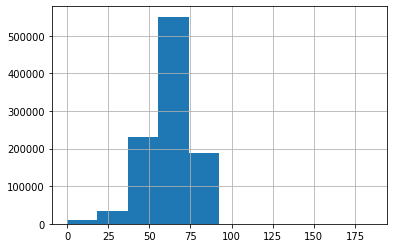

In [35]:
df["current-energy-efficiency"].hist()
plt.show()

In [36]:
# Energy efficiency ratings should only go up to 100
df = df[df["current-energy-efficiency"] <=100]
print(f"Min: {df['current-energy-efficiency'].min()}")
print(f"Max: {df['current-energy-efficiency'].max()}")

Min: 0
Max: 100


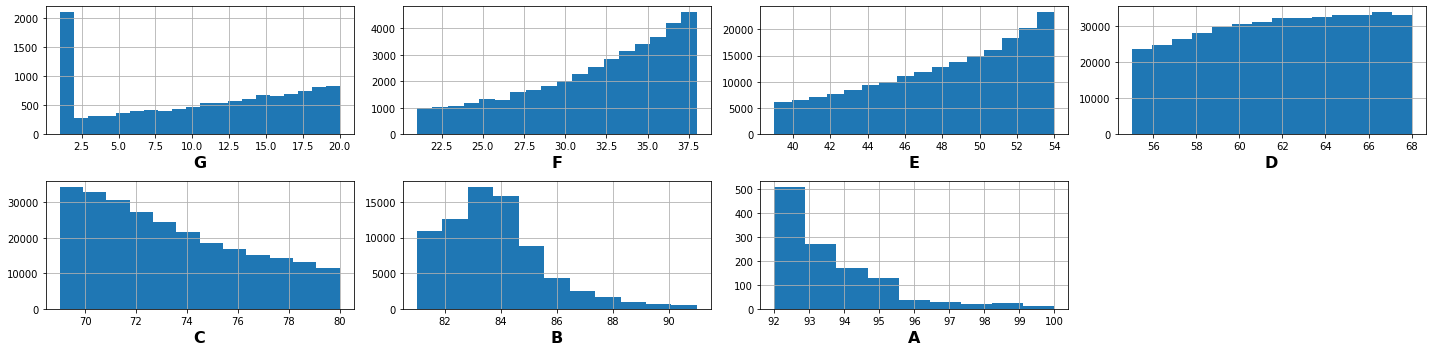

In [37]:
plt.figure(figsize=(20,5))

bands = ['G', 'F', 'E', 'D', 'C', 'B','A']

for i, band in enumerate(bands):
  epc_bands = df[df["current-energy-rating"] == band]
  plt.subplot(241+i)
  bins = len(epc_bands['current-energy-efficiency'].unique())
  epc_bands['current-energy-efficiency'].hist(bins=bins)
  plt.xlabel(band,fontsize=16, weight='bold')

plt.tight_layout()

# Impute missing values

For values which do not change often over time such as `built-form` (detached, terraced etc), it's safe to use the data from previous certificates where available to fill the missing values in more recent certificates.


In [38]:
epc_grouped = df.groupby(['uprn'], as_index=False)['inspection-date'].count()
epc_grouped_2plus = epc_grouped[epc_grouped['inspection-date'] > 1]
epc_2plus = df.merge(epc_grouped_2plus[['uprn']], on = 'uprn', how = 'inner')

In [39]:
# note this takes a while
fill_columns = ['built-form', 'floor-level','number-habitable-rooms','floor-description',
                'roof-description','heat-loss-corridor','walls-description','floor-height',
                'mains-gas-flag']

for c in fill_columns:
    print(c)
    epc_2plus[c] = epc_2plus.groupby(['uprn'], sort=False)[c].apply(lambda x: x.ffill())

built-form
floor-level
number-habitable-rooms
floor-description
roof-description
heat-loss-corridor
walls-description
floor-height
mains-gas-flag


In [40]:
epc_grouped_1 = epc_grouped[epc_grouped['inspection-date'] == 1]
epc_1 = df.merge(epc_grouped_1[['uprn']], on='uprn', how='inner')

In [41]:
# merging filled data for buildings with more than one certificate with data for buildings with only one certificate
epc_filled = pd.concat([epc_1,epc_2plus])

In [42]:
# checking length of filled data (should be the)
print(f"Missing rows: {len(df) - len(epc_filled)}")
print(f"Property without UPRN: {len(df[df.uprn.isna()])}")

Missing rows: 13443
Property without UPRN: 13443


In [43]:
# remove rows without UPRN, doesn't exist and cannot find data
df = df[df.uprn.isna()==False]

# Standardising missing data labels

In [44]:
# replace 'NO DATA!', 'not defined' and 'not recored' with null
df = df.replace(['NO DATA!','NODATA!'],np.nan)
df = df.replace(['not recorded','not defined','unknown','Unknown','Not defined','Not recorded'],np.nan)
df = df.replace(['N/A','n/a'],np.nan)
df = df.replace(['INVALID!'],np.nan)

# Data Audit
This script takes an audit of the EPC data for WMCA. It looks at how many missing values each feature has, how many unique values the categorical features have then applies preprocessing steps to remove outliers and drop features with too many missing values. Note that [Sonia Williams](https://datasciencecampus.ons.gov.uk/projects/using-machine-learning-to-predict-energy-efficiency/) split the data into test and training before performing the following.

## Missing values

In [45]:
percent_missing = df.isnull().sum() * 100 / len(df)

In [46]:
percent_missing.sort_values(ascending=False)[:30]

ladnmw                          100.000000
sheating-energy-eff             100.000000
sheating-env-eff                100.000000
county                           99.871190
doterm                           99.538805
floor-energy-eff                 94.937261
floor-env-eff                    94.937261
address3                         94.880112
flat-storey-count                93.131414
unheated-corridor-length         85.571435
heat-loss-corridor               73.892526
flat-top-storey                  73.409612
floor-level                      70.864631
address2                         67.631660
floor-height                     59.585064
low-energy-fixed-light-count     59.315033
fixed-lighting-outlets-count     52.560544
photo-supply                     40.685367
solar-water-heating-flag         38.887226
roof-env-eff                     17.354673
roof-energy-eff                  17.354673
main-heating-controls            16.255431
glazed-type                      10.986115
energy-tari

Maybe we can map values from `photo-supply` to `solar-water-heating-flag`.

In [47]:
df.drop([
        # Remove variables with too many missing variables
        'sheating-env-eff', 'sheating-energy-eff', 'flat-storey-count', 
        'floor-env-eff', 'floor-energy-eff', 'unheated-corridor-length', 
        'county', 'heat-loss-corridor', 'flat-top-storey', 
        # Remove unnecessary variables
        'oa11cd', 'lsoa11cd', 'msoa11cd', 'lsoa11nm', 'msoa11nm', 
        'local-authority-label',
        # Remove variables with high % missing and similar variables
        'low-energy-fixed-light-count', 'fixed-lighting-outlets-count'
        ],
        axis=1,
        inplace=True)


## Data sanity check

In [48]:
# Convert to datetime object
df['inspection-date'] = df['inspection-date'].astype('datetime64')
df['lodgement-datetime'] = df['lodgement-datetime'].astype('datetime64')

## remove similar column
df.drop(columns=['lodgement-date'], inplace=True)

In [49]:
# All valid years
df['inspection-date'].dt.year.value_counts(normalize=True)

2014    0.118199
2013    0.114531
2009    0.088470
2015    0.084768
2016    0.077105
2010    0.072140
2011    0.062521
2012    0.062021
2021    0.061722
2019    0.058548
2020    0.057052
2018    0.054500
2017    0.047167
2008    0.025319
2022    0.015847
2007    0.000071
2006    0.000018
2003    0.000001
2004    0.000001
Name: inspection-date, dtype: float64

In [50]:
# All valid years
df['lodgement-datetime'].dt.year.value_counts(normalize=True)

2014    0.117681
2013    0.113594
2009    0.088913
2015    0.085585
2016    0.077752
2010    0.072348
2011    0.062653
2021    0.062100
2012    0.061818
2019    0.058759
2020    0.056798
2018    0.053940
2017    0.047160
2008    0.024217
2022    0.016681
Name: lodgement-datetime, dtype: float64

## Clip values in numeric columns that are too high or negative

In [51]:
num_var = df.select_dtypes(include= 'number').columns.tolist()

# Not these variables
num_var.remove('uprn')
num_var.remove('LATITUDE')
num_var.remove('LONGITUDE')

# Fuel poverty data is fine
num_var.remove('prop_households_fuel_poor')
num_var.remove('num_households')
num_var.remove('num_households_fuel_poverty')

In [52]:
audit_num = df[num_var].describe(percentiles = [0.25,0.5,0.75,0.9,0.95,0.99])

In [53]:
# Clips the variables of the EPC data between 0 and the upper bound of the 99% confidence interval
for var in num_var:
  df[var].clip(lower=0.0, upper=audit_num[var]['99%'], inplace=True)

## Reduce levels in categorical fields
We will need to group categories for those with many levels using CHAID and other methods in the next notebook.

In [54]:
cat_var = df.select_dtypes(include= ['object','category']).columns.tolist()

# Not these variables
cat_var.remove('lmk-key')
cat_var.remove('address')
cat_var.remove('postcode')

In [55]:
df[cat_var].nunique().sort_values(ascending = False)[:30]

address1                    684694
address2                     22240
address3                      2995
walls-description              613
floor-description              404
roof-description               300
posttown                       236
lighting-description           185
mainheat-description           156
main-heating-controls          111
hotwater-description            93
mainheatcont-description        65
floor-level                     53
windows-description             45
constituency-label              44
constituency                    44
secondheat-description          40
main-fuel                       38
construction-age-band           29
local-authority                 23
transaction-type                17
energy-tariff                    9
glazed-type                      8
current-energy-rating            7
tenure                           7
ladcd                            7
ladnm                            7
potential-energy-rating          7
glazed-area         

In [56]:
df.to_csv("/content/drive/MyDrive/WMCA/data_cleaning.csv", index=False)